# ML Analysis: Cross-selling effects

* Problem statement
  * The product category furniture does not produce many profits, even losses. Therefore, the questions arises if it is still useful to keep this product in the portfolio.
  * Generally, furniture has higher operational costs for logistics (storage, transportation).
  * Thus, the company could make a shift in the product portfolio.
* Approach
  * Analyse the cross-selling effects in the product portfolio using clustering.
  * Product-Level Clustering (Product Affinity/Market Basket Analysis)
    * uncover co-purchase patterns
    * co-occurrence matrix
  * Customer Segmentation based on Purchase Behavior
* Assumption:
  * It is still useful to keep the products in the portfolio, because what is a office stuff shop without furniture? It is going to entice customers. We need to quantify this anyhow and preferebly see that over time.
  * The product segment is growing.
* Further questions: 
  * How can profits be maximized?

In [289]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import yaml

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, RobustScaler

In [291]:
with open('../config.yaml') as file:
    config = yaml.safe_load(file)

# Getting dem data

In [292]:
db_path = Path(config['processed_data']['database_sqlite'])
query_path = Path(config['queries_path'])

with sqlite3.connect(db_path) as conn:
    
    with open(query_path.joinpath('create_views.sql'), 'r') as f:
        conn.executescript(f.read())

    with open(query_path.joinpath('select_data_for_product_segmentation.sql'), 'r') as f:
        # cur = conn.executescript(f.read())
        df = pd.read_sql_query(f.read(), conn)

In [293]:
df = df.set_index('CustomerID')        
df.head()

,NumOrders,Sales,Profit,SalesTechnology,SalesOfficeSupplies,SalesFurniture,SalesFurnitureChair,SalesFurnitureTables,SalesFurnitureFurnishings,SalesFurnitureBookcases,SalesFurnitureNotProfitable,SalesFurnitureProfitable,HasBoughtFurniture
CustomerID,,,,,,,,,,,,,
AA-10315,5,5563.560,-362.8825,473.696,5075.304,14.560,0.000,0.00,14.56,0.000,0.000,14.560,1
AA-10375,9,1056.390,277.3824,766.930,261.060,28.400,0.000,0.00,28.40,0.000,0.000,28.400,1
AA-10480,4,1790.512,435.8274,689.940,625.272,475.300,0.000,447.84,27.46,0.000,447.840,27.460,1
AA-10645,6,5086.935,857.8033,354.682,981.540,3750.713,2347.888,0.00,123.66,1279.165,2347.888,1402.825,1
AB-10015,3,886.156,129.3465,221.980,273.504,390.672,48.712,0.00,0.00,341.960,48.712,341.960,1


# Data Prepping

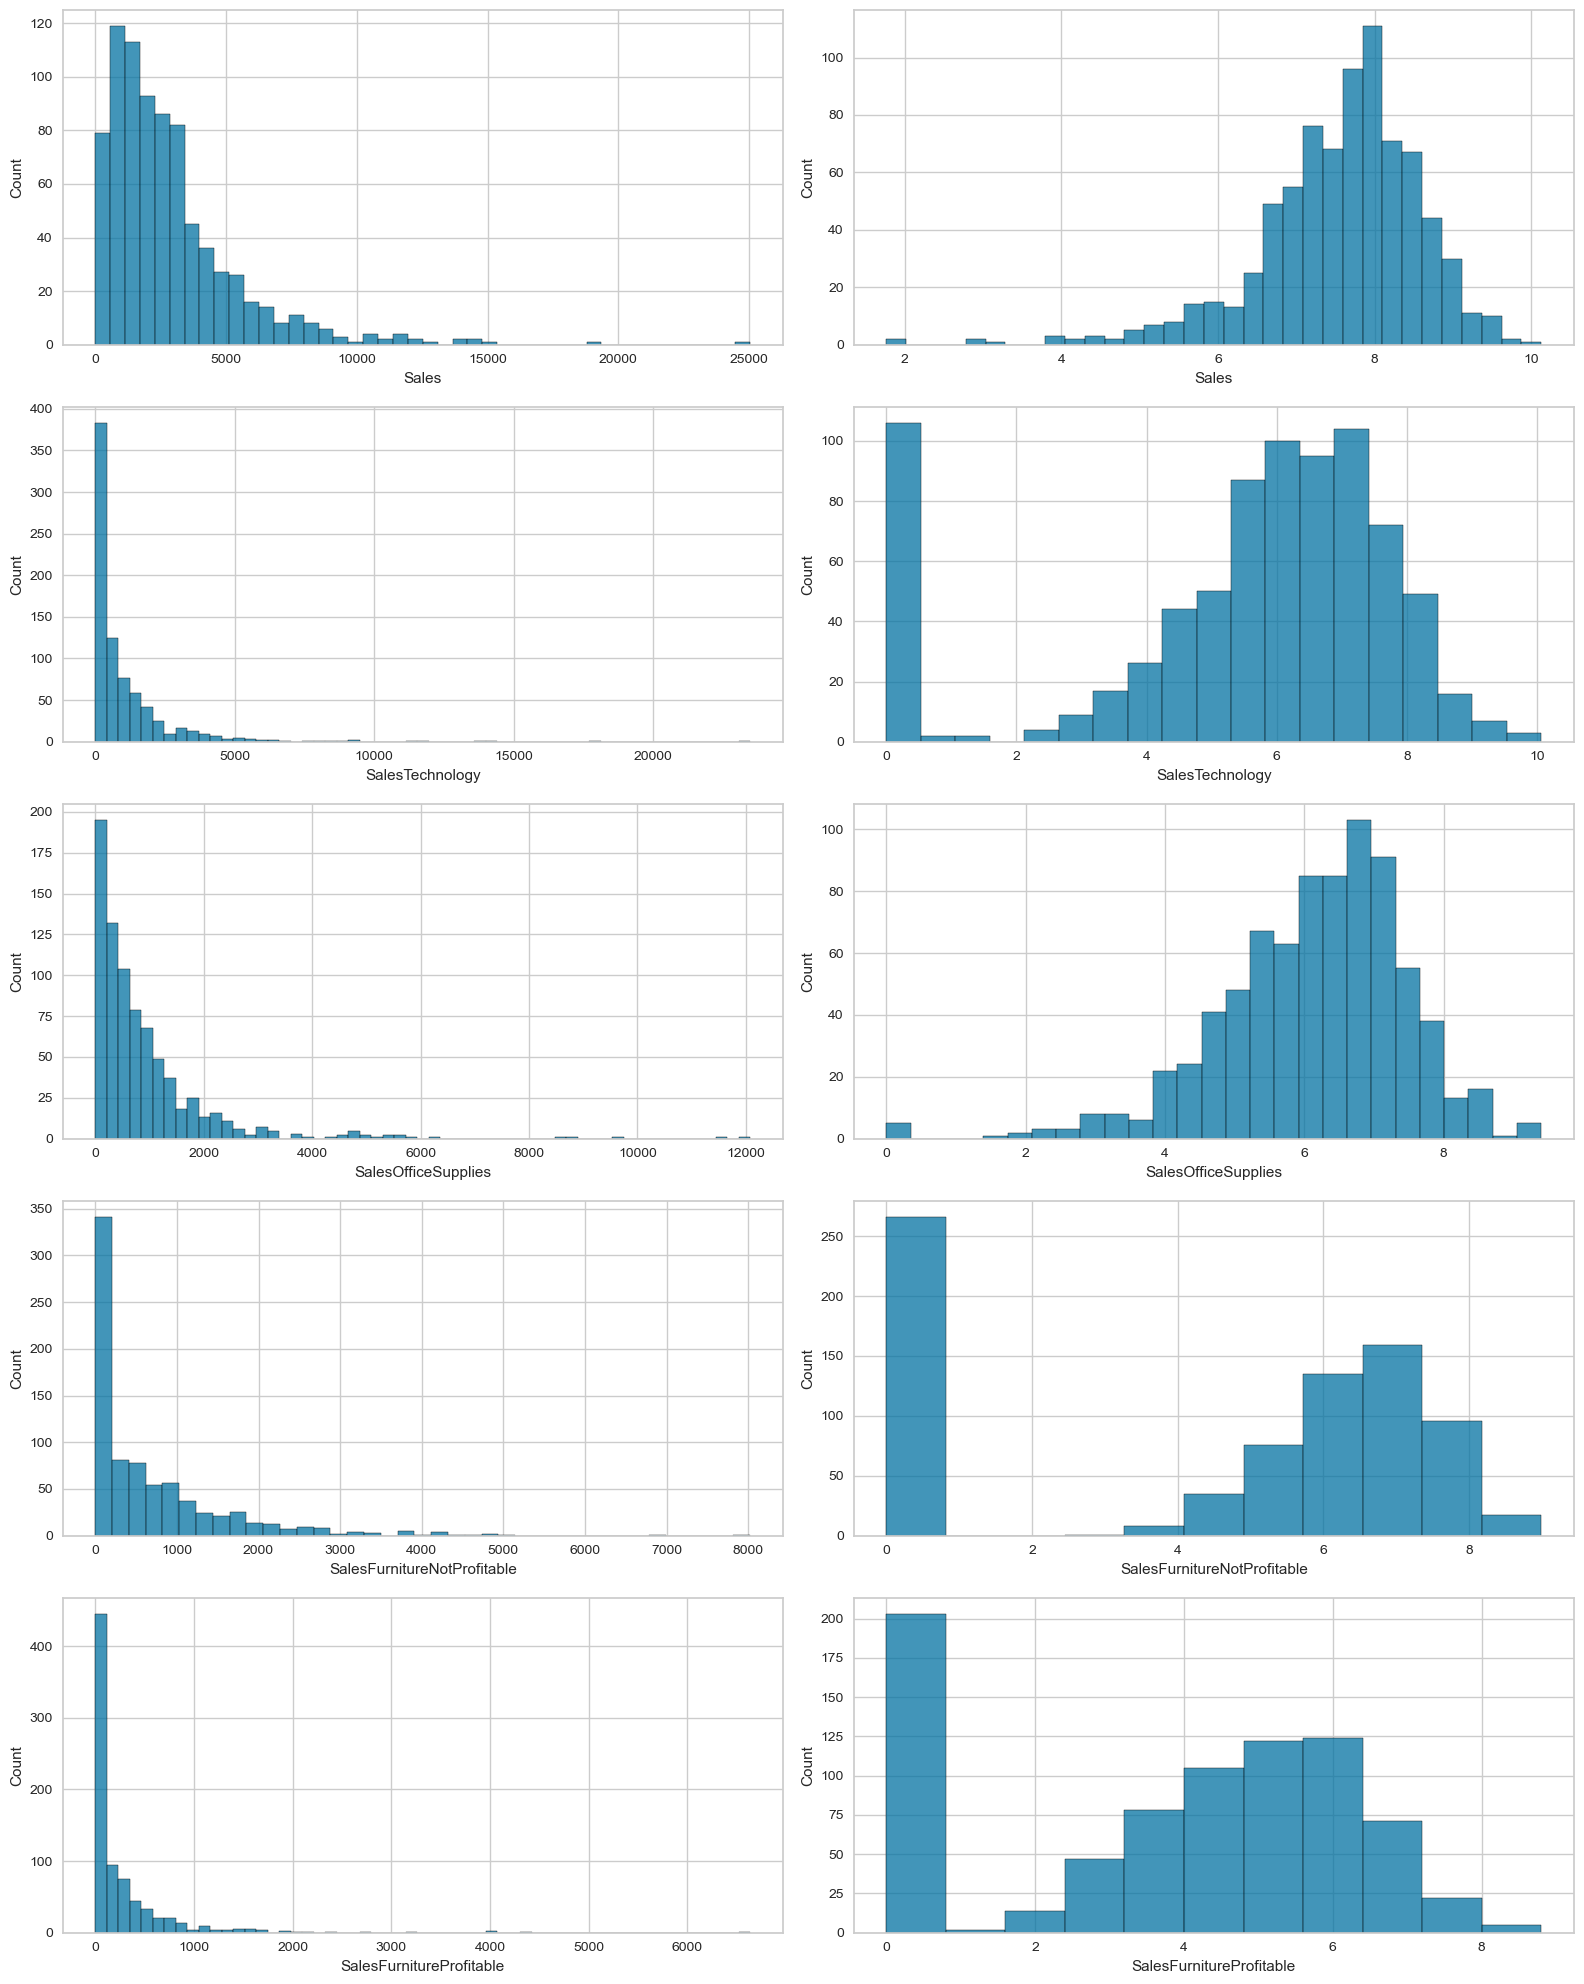

In [294]:
# check skew
numeric_features = [
    'Sales', 'SalesTechnology', 'SalesOfficeSupplies',
    # 'SalesFurniture', 
    # 'SalesFurnitureChair', 'SalesFurnitureTables', 'SalesFurnitureFurnishings', 'SalesFurnitureBookcases'
    'SalesFurnitureNotProfitable', 'SalesFurnitureProfitable'
    ]

fig, axs = plt.subplots(len(numeric_features), 2, figsize=(16, 20))

for feat, ax in zip(numeric_features, axs[:,0]):
    sns.histplot(df[feat], ax=ax)

for feat, ax in zip(numeric_features, axs[:,1]):
    sns.histplot(np.log1p(df[feat]), ax=ax)

plt.tight_layout()

* Dem data is damn skewed: apply a log1p transformation to get dem data more nice.
* There are some outliers that might not be relevant for this analysis, since we want to see the usual customers behaviour.

# Machine Learning

In [295]:
X=df

In [296]:
# --- Pre-processing: Scaling the features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
print("\nScaled Customer Features:")
X_scaled_df


Scaled Customer Features:


,NumOrders,Sales,Profit,SalesTechnology,SalesOfficeSupplies,SalesFurniture,SalesFurnitureChair,SalesFurnitureTables,SalesFurnitureFurnishings,SalesFurnitureBookcases,SalesFurnitureNotProfitable,SalesFurnitureProfitable,HasBoughtFurniture
CustomerID,,,,,,,,,,,,,
AA-10315,-0.516429,1.015112,-0.810161,-0.311961,3.452181,-0.858150,-0.572564,-0.456520,-0.495664,-0.318939,-0.717510,-0.487513,0.34877
AA-10375,1.052644,-0.700590,-0.093739,-0.154437,-0.534720,-0.845256,-0.572564,-0.456520,-0.427800,-0.318939,-0.717510,-0.460080,0.34877
AA-10480,-0.908697,-0.421139,0.083553,-0.195796,-0.233099,-0.428911,-0.572564,0.326833,-0.432409,-0.318939,-0.241590,-0.461943,0.34877
AA-10645,-0.124161,0.833680,0.555721,-0.375895,0.061943,2.622564,2.673124,-0.456520,0.039310,2.497255,1.777591,2.264242,0.34877
AB-10015,-1.300965,-0.765391,-0.259383,-0.447182,-0.524415,-0.507753,-0.505226,-0.456520,-0.567060,0.433916,-0.665744,0.161445,0.34877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
XP-21865,1.837181,-0.198777,0.291008,-0.434733,0.340752,-0.115885,-0.572564,-0.456520,3.411158,-0.318939,-0.717510,1.091745,0.34877
YC-21895,-0.516429,0.973540,1.056814,0.255243,2.396356,-0.755811,-0.572564,-0.456520,0.042988,-0.318939,-0.717510,-0.269773,0.34877
YS-21880,0.660376,1.455492,1.585699,-0.439650,3.905936,-0.069372,0.031129,0.170702,-0.243721,-0.318939,0.127639,-0.385669,0.34877


In [297]:
# Select features for clustering
# It's usually good to exclude 'Total_Spend_Overall' if you have granular category spends
features_excluded = ['Sales', 'SalesFurniture', 'SalesFurnitureChair', 'SalesFurnitureTables', 'SalesFurnitureFurnishings', 'SalesFurnitureBookcases']
features = [col for col in df.columns if col not in features_excluded]
X = df[features]
X.head()

,NumOrders,Profit,SalesTechnology,SalesOfficeSupplies,SalesFurnitureNotProfitable,SalesFurnitureProfitable,HasBoughtFurniture
CustomerID,,,,,,,
AA-10315,5,-362.8825,473.696,5075.304,0.000,14.560,1
AA-10375,9,277.3824,766.930,261.060,0.000,28.400,1
AA-10480,4,435.8274,689.940,625.272,447.840,27.460,1
AA-10645,6,857.8033,354.682,981.540,2347.888,1402.825,1
AB-10015,3,129.3465,221.980,273.504,48.712,341.960,1


In [298]:
# --- Determine Optimal Number of Clusters (Elbow Method Example) ---
# In a real scenario, you'd plot and analyze this more carefully
km = []
inertia = []
silhouette = []
dbi = []
max_num_clusters = 50 # len(df)-1
range_clusters = range(2, max_num_clusters)
for k in range_clusters: # K can't be more than number of samples
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    km.append(kmeans)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.labels_))
    dbi.append(davies_bouldin_score(X_scaled_df, kmeans.labels_))

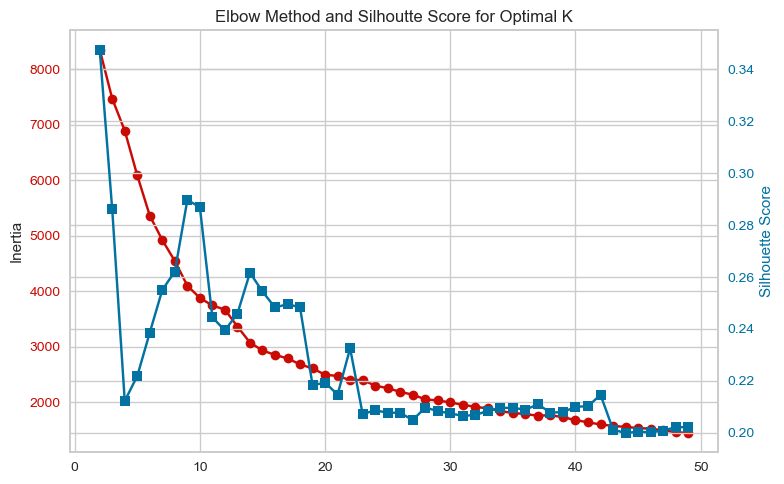

In [299]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot temperature on the left y-axis
ax1.plot(range_clusters, inertia, 'r-o')
ax1.set_ylabel('Inertia')
ax1.tick_params(axis='y', labelcolor='r')


# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(range_clusters, silhouette, 'b-s')#, label='Electricity Consumption (kWh)')
ax2.set_ylabel('Silhouette Score', color='b')
ax2.tick_params(axis='y', labelcolor='b')


plt.title('Elbow Method and Silhoutte Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.grid(True)
plt.tight_layout()
plt.show()

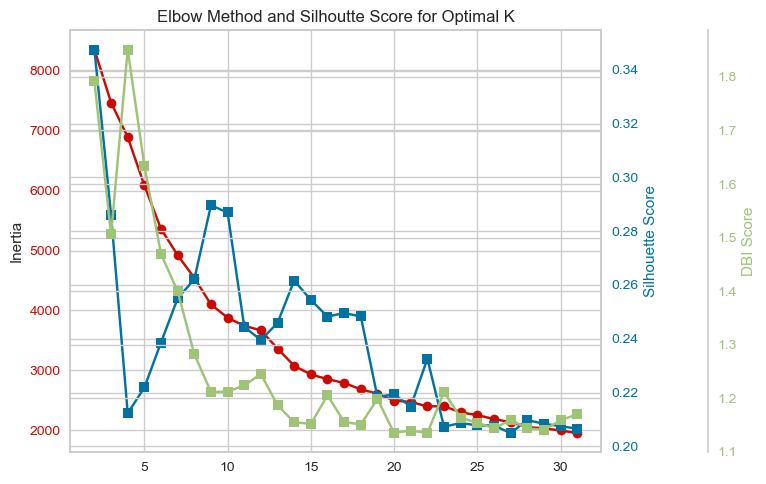

In [300]:
fig, ax1 = plt.subplots(figsize=(8, 5))

n_clusters = 30

ax2 = ax1.twinx()
ax3 = ax1.twinx()

# ax2.spines.left.set_position(("axes", 0.))
ax3.spines["right"].set_position(("axes", 1.2)) # Position ax3's right spine at 120% of the axes width
# Make sure to make ax3's spine visible, and also set its color if needed
ax3.spines["right"].set_visible(True)

# Plot temperature on the left y-axis
ax1.plot(range_clusters[:n_clusters], inertia[:n_clusters], 'r-o')
ax1.set_ylabel('Inertia')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for silhouette score
ax2.plot(range_clusters[:n_clusters], silhouette[:n_clusters], 'b-s')#, label='Electricity Consumption (kWh)')
ax2.set_ylabel('Silhouette Score', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Create a third y-axis for DBI Score
ax3.plot(range_clusters[:n_clusters], dbi[:n_clusters], 'g-s')#, label='Electricity Consumption (kWh)')
ax3.set_ylabel('DBI Score', color='g')
ax3.tick_params(axis='y', labelcolor='g')

plt.title('Elbow Method and Silhoutte Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [301]:
km[0].n_clusters

2

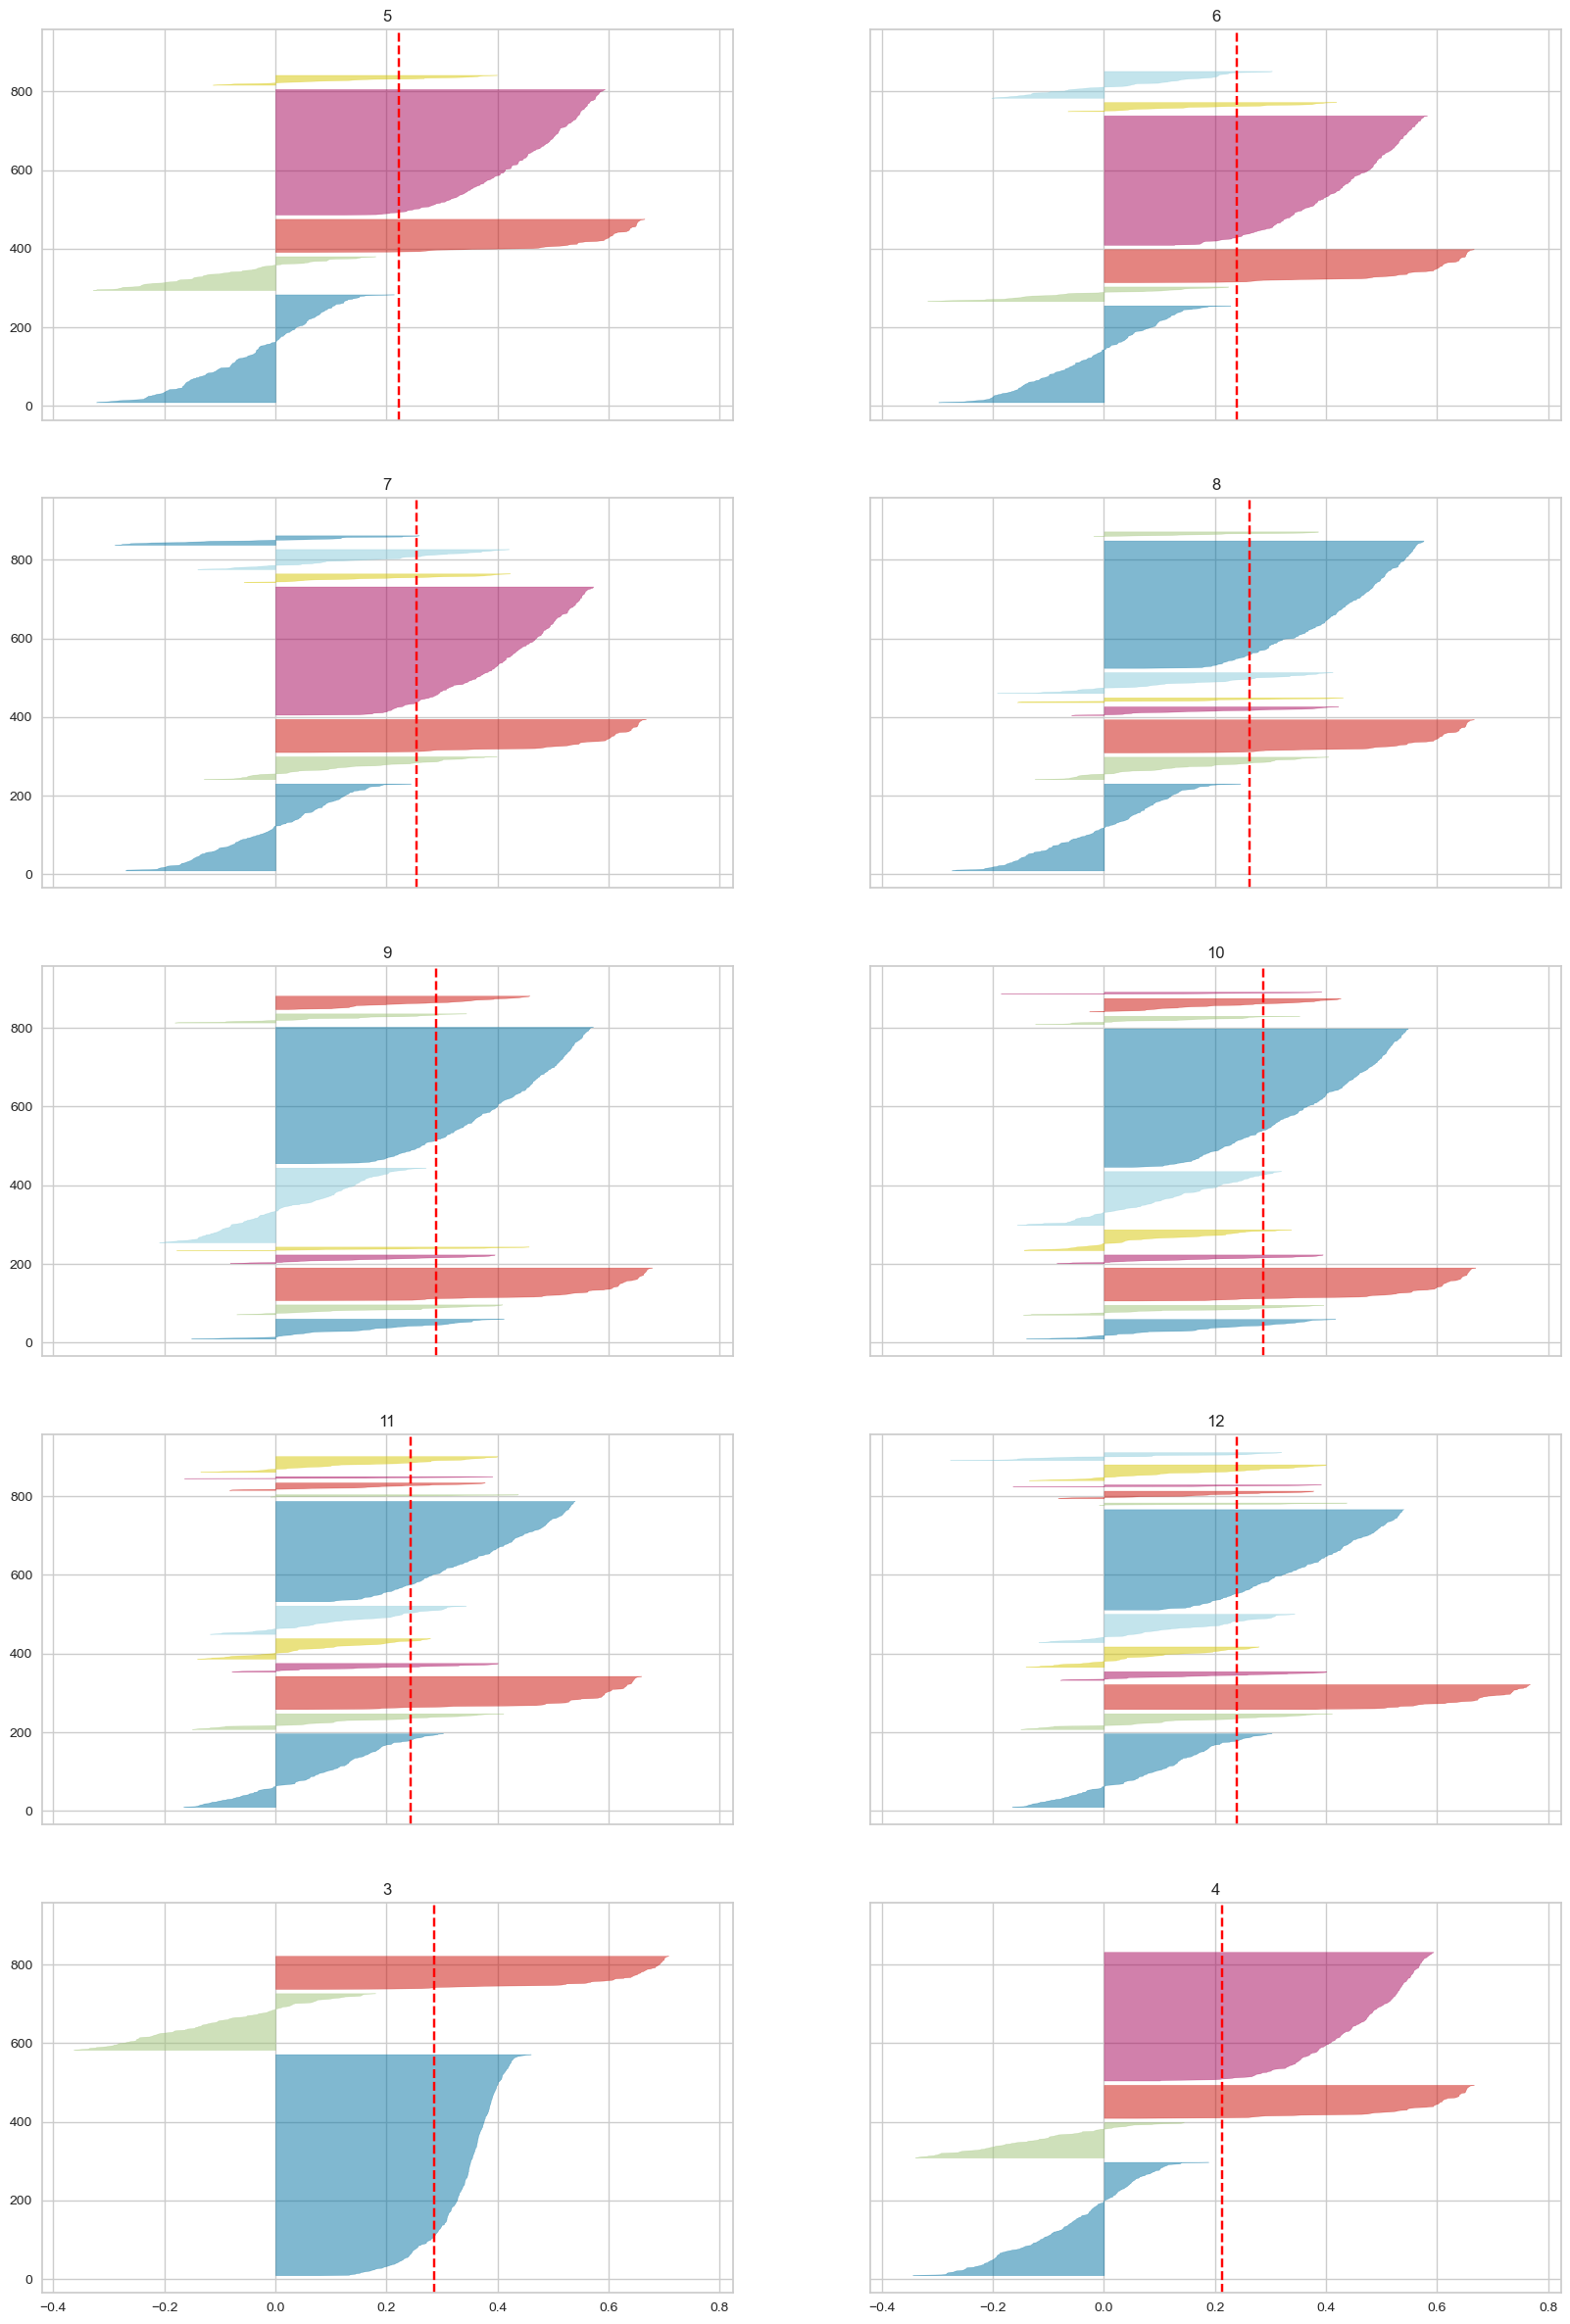

In [302]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(5, 2, figsize=(20,30), sharex=True, sharey=True)

for i, k in enumerate(km[1:11]):
    '''
    Create KMeans instance for different number of clusters
    '''
    # km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(k, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_scaled)
    ax[q-1][mod].set_title(f'{k.n_clusters}')

In [303]:
inertia_diff = pd.Series(inertia[:-1]) - pd.Series(inertia[1:])
inertia_diff.index = (inertia_diff.index+1)
inertia_diff

1     883.199718
2     575.212654
3     806.402239
4     723.778840
5     439.521787
6     377.253203
7     443.295075
8     221.412642
9     135.670506
10     73.620543
11    304.890006
12    288.505447
13    142.550511
14     78.725419
15     64.209533
16    105.708633
17     74.697829
18    112.535659
19     22.879987
20     75.030341
21     -4.377596
22    104.428282
23     43.271469
24     68.004323
25     49.978471
26     83.468886
27     21.287736
28     34.334571
29     44.112582
30     35.617448
31     28.922793
32     52.014353
33     26.576148
34     25.088661
35     26.194251
36     -7.414359
37     35.100388
38     52.771677
39     38.927342
40     39.791577
41     25.466173
42     17.817414
43     21.435556
44     10.213479
45     31.252365
46     30.800813
47     18.062469
dtype: float64

In [310]:
# select optimal number of clusters from the above plot
optimal_k = 10
print('Inertia Diff', inertia_diff[optimal_k])
print('Silhouette', silhouette[optimal_k-2])
print('DBI', dbi[optimal_k-2])

Inertia Diff 73.62054300522732
Silhouette 0.28696167162300346
DBI 1.2126347959777684


In [305]:
# --- Perform K-Means Clustering ---
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df['Cluster'] = kmeans_model.fit_predict(X_scaled)

print(f"\nCustomer Data with {optimal_k} Clusters:")
df.head()


Customer Data with 9 Clusters:


,NumOrders,Sales,Profit,SalesTechnology,SalesOfficeSupplies,SalesFurniture,SalesFurnitureChair,SalesFurnitureTables,SalesFurnitureFurnishings,SalesFurnitureBookcases,SalesFurnitureNotProfitable,SalesFurnitureProfitable,HasBoughtFurniture,Cluster
CustomerID,,,,,,,,,,,,,,
AA-10315,5,5563.560,-362.8825,473.696,5075.304,14.560,0.000,0.00,14.56,0.000,0.000,14.560,1,7
AA-10375,9,1056.390,277.3824,766.930,261.060,28.400,0.000,0.00,28.40,0.000,0.000,28.400,1,6
AA-10480,4,1790.512,435.8274,689.940,625.272,475.300,0.000,447.84,27.46,0.000,447.840,27.460,1,6
AA-10645,6,5086.935,857.8033,354.682,981.540,3750.713,2347.888,0.00,123.66,1279.165,2347.888,1402.825,1,1
AB-10015,3,886.156,129.3465,221.980,273.504,390.672,48.712,0.00,0.00,341.960,48.712,341.960,1,6


In [311]:
# cluster profiling
cluster_profiles = df.groupby('Cluster').mean()
print("\nCluster Profiles (Average Feature Values within each Cluster):")
cluster_profiles[features]


Cluster Profiles (Average Feature Values within each Cluster):


,NumOrders,Profit,SalesTechnology,SalesOfficeSupplies,SalesFurnitureNotProfitable,SalesFurnitureProfitable,HasBoughtFurniture
Cluster,,,,,,,
0,7.480769,366.258813,871.864058,767.521058,561.688500,775.690792,1.000000
1,8.307692,914.084327,1469.910385,1192.732000,3723.208038,296.189281,1.000000
2,4.345238,142.129488,661.291417,599.665500,0.000000,0.000000,0.000000
3,7.043478,375.348678,978.827913,706.648696,572.411304,2316.641896,1.000000
4,6.000000,3691.677190,12731.391200,760.524700,446.828700,315.998300,0.900000
5,7.989529,511.572738,1666.159319,1045.365623,1012.688767,207.913968,1.000000
6,5.258621,127.109291,509.009905,562.036216,258.546027,141.853066,1.000000
7,8.500000,1697.930912,643.059458,6007.443750,832.825125,316.885875,0.958333
8,7.342857,97.198117,1040.534143,984.649971,2525.265771,154.967871,1.000000


In [312]:
# unscale the profiles for easier interpretation
cluster_profiles_unscaled = pd.DataFrame(
    scaler.inverse_transform(cluster_profiles),
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
    )
print("\nCluster Profiles (Unscaled Averages):")
cluster_profiles_unscaled


Cluster Profiles (Unscaled Averages):


,NumOrders,Sales,Profit,SalesTechnology,SalesOfficeSupplies,SalesFurniture,SalesFurnitureChair,SalesFurnitureTables,SalesFurnitureFurnishings,SalesFurnitureBookcases,SalesFurnitureNotProfitable,SalesFurnitureProfitable,HasBoughtFurniture
Cluster,,,,,,,,,,,,,
0,25.387063,7.822893e+06,3.276858e+05,1.624049e+06,9.277002e+05,1.436461e+06,2.701180e+05,1.082280e+05,140168.532611,40542.261409,5.292235e+05,3.915979e+05,1.202498
1,27.495118,1.755670e+07,8.172763e+05,2.737326e+06,1.441149e+06,4.315304e+06,2.354404e+06,2.684351e+05,25010.608005,79231.554065,3.504211e+06,1.496885e+05,1.202498
2,17.393729,3.315446e+06,1.273820e+05,1.232063e+06,7.250120e+05,9.356870e+02,4.141855e+02,2.609906e+02,115.643334,144.867587,6.751761e+02,2.605109e+02,0.891551
3,24.272287,1.202024e+07,3.358094e+05,1.823165e+06,8.541959e+05,3.102007e+06,2.407022e+05,1.376056e+05,28499.591092,989185.882833,5.393137e+05,1.169010e+06,1.202498
4,21.612174,3.745028e+07,3.299605e+06,2.370083e+07,9.192520e+05,8.197441e+05,2.656788e+05,4.607135e+04,44136.780039,45630.085987,4.211406e+05,1.596822e+05,1.171403
5,26.684031,1.033264e+07,4.575526e+05,3.102648e+06,1.263202e+06,1.311115e+06,5.080312e+05,1.780391e+05,17411.661986,56060.224107,9.536144e+05,1.051535e+05,1.202498
6,19.722193,3.868401e+06,1.139584e+05,9.485879e+05,6.795741e+05,4.307188e+05,1.232631e+05,5.098265e+04,13610.731872,34519.879784,2.439668e+05,7.182563e+04,1.202498
7,27.985363,2.049415e+07,1.517798e+06,1.198124e+06,7.254987e+06,1.235020e+06,3.159922e+05,2.269811e+05,46354.689388,41093.363965,7.843629e+05,1.601300e+05,1.189542
8,25.035487,1.236409e+07,8.722690e+04,1.938032e+06,1.189887e+06,2.877863e+06,1.977858e+05,1.287962e+06,16380.478278,34307.893670,2.376948e+06,7.844207e+04,1.202498


In [314]:
df.head()

,NumOrders,Sales,Profit,SalesTechnology,SalesOfficeSupplies,SalesFurniture,SalesFurnitureChair,SalesFurnitureTables,SalesFurnitureFurnishings,SalesFurnitureBookcases,SalesFurnitureNotProfitable,SalesFurnitureProfitable,HasBoughtFurniture,Cluster
CustomerID,,,,,,,,,,,,,,
AA-10315,5,5563.560,-362.8825,473.696,5075.304,14.560,0.000,0.00,14.56,0.000,0.000,14.560,1,7
AA-10375,9,1056.390,277.3824,766.930,261.060,28.400,0.000,0.00,28.40,0.000,0.000,28.400,1,6
AA-10480,4,1790.512,435.8274,689.940,625.272,475.300,0.000,447.84,27.46,0.000,447.840,27.460,1,6
AA-10645,6,5086.935,857.8033,354.682,981.540,3750.713,2347.888,0.00,123.66,1279.165,2347.888,1402.825,1,1
AB-10015,3,886.156,129.3465,221.980,273.504,390.672,48.712,0.00,0.00,341.960,48.712,341.960,1,6


In [309]:
# Analyze 'Has_Purchased_LowProfitCatX' for each cluster
low_profit_presence = df.groupby('Cluster')[['Sales', 'Profit', 'HasBoughtFurniture']].agg({
    'Sales'                 : ('mean', 'sum'), 
    'Profit'                : ('mean', 'sum'), 
    'HasBoughtFurniture'    : 'mean'
    })

print("\nAverage 'HasBoughtFurniture' per Cluster (Proportion of Cluster buying it):")
low_profit_presence.sort_values(('Profit', 'sum'), ascending=False)


Average 'HasBoughtFurniture' per Cluster (Proportion of Cluster buying it):


Sales                    Profit             HasBoughtFurniture
                 mean          sum         mean         sum               mean
Cluster                                                                       
5         3932.127677  751036.3863   511.572738  97710.3930           1.000000
6         1471.445214  512062.9344   127.109291  44234.0334           1.000000
7         7800.214208  187205.1410  1697.930912  40750.3419           0.958333
4        14254.742900  142547.4290  3691.677190  36916.7719           0.900000
1         6682.039704  173733.0323   914.084327  23766.1925           1.000000
0         2976.764408  154791.7492   366.258813  19045.4583           1.000000
2         1260.956917  105920.3810   142.129488  11938.8770           0.000000
3         4574.529809  105214.1856   375.348678   8633.0196           1.000000
8         4705.417757  164689.6215    97.198117   3401.9341           1.000000